In [2]:
noExt=function(x){
return(tools::file_path_sans_ext(x))
}
bnoExt=function(x){
return(basename(tools::file_path_sans_ext(x)))
}
fNumber=function(x){
sapply(x,FUN=function(x){
strsplit(x,"__")[[1]][2]
})
}
rRider=function(x){
sapply(x,FUN=function(x){
strsplit(x,"-RIDER")[[1]][1]
})
}
# centering with 'scale()'
center_scale <- function(x) {
    scale(x, scale = FALSE)
}
#LOAD LIBRARIES 
library(gtools);
library("GenomicRanges");
options(warn=-1)
library(ggplot2)

In [3]:
#SETTING PATH 
pathcutTagMet="/sharedFolder/Data/4_cutTagMet/"
results="/sharedFolder/Results/Sequencing"
previousResults="/sharedFolder/Results/Hotspot/"


In [4]:
dir.create(results,recursive=TRUE)
results="/sharedFolder/Results/Sequencing/cutTagMet"
dir.create(results,recursive=TRUE)

In [7]:
gtf=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")
gtf=gtf[grep("Ligase",gtf[,6]),]
a=list.files(pathcutTagMet,pattern=".bedgraph",recursive=TRUE)
uu=grep("sorted",a)
if(length(uu)!=0){
a=a[-uu]
    }
a=mixedsort(a)
a2=sapply(a,FUN=function(x){strsplit(x,".bedgraph")[[1]][1]})
groseq_count=matrix(0,ncol=length(unique(gtf[,7])),nrow=length(a2))
colnames(groseq_count)=sapply(unique(gtf[,7]),FUN=toString)
rownames(groseq_count)=a2
groseq_rpm=groseq_count
for(j in a){
    system(paste("echo",j))
temp=read.table(paste(pathcutTagMet,"/",j,sep=""),sep="\t")
tempGG=GRanges(seqnames=as.matrix(temp[,1]),ranges=IRanges(start = as.numeric(temp[,2]),end=as.numeric(temp[,3])),mcols=abs(as.numeric(temp[,4])))
    for(i in seq(nrow(gtf))){
        system(paste("echo",i/nrow(gtf)))
        gg=GRanges(seqnames=as.matrix(gtf[i,1]),ranges=IRanges(start = as.numeric(gtf[i,2]),end=as.numeric(gtf[i,3])))    
        over=findOverlaps(gg,tempGG)@to    
        name=as.vector(noExt((j)))
        groseq_count[name,toString(gtf[i,7])]= sum(tempGG[over]$mcols)
        groseq_rpm[name,toString(gtf[i,7])]= (sum(tempGG[over]$mcols)/sum(abs(temp[,4])))*1000000

   }

}
write.table((t(groseq_count)),paste(results,"/cutTagMet_AID_Heatmap_count.csv",sep=""),col.names=NA,sep=",")
write.table((t(groseq_rpm)),paste(results,"/cutTagMet_AID_Heatmap_RPM.csv",sep=""),col.names=NA,sep=",")


[1] "RAW"


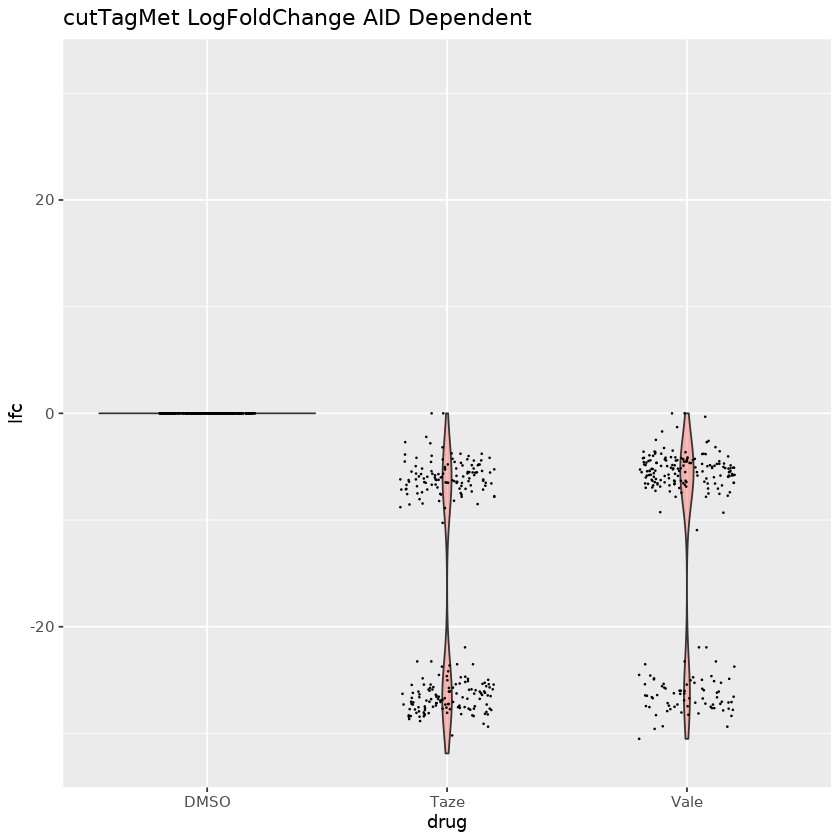

In [14]:
print("RAW")
Database=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")
cutTagMet_newrpm=as.matrix(read.table(paste(results,"/cutTagMet_AID_Heatmap_count.csv",sep=""),header=TRUE,row.names=1,sep=","))

filterVale=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/Lig_DMSOVale.csv",header=TRUE,row.names=1,sep=",")))
filterVale=unlist(sapply(filterVale,FUN=function(x){toString(x)}))

filterTaze=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/Lig_DMSOTaze.csv",header=TRUE,row.names=1,sep=",")))
filterTaze=unlist(sapply(filterTaze,FUN=function(x){toString(x)}))

#ttmp=cutTagMet_newrpm[which(cutTagMet_newrpm[,1]>=summary(cutTagMet_newrpm[,1])[5]),]
#thresholdTheBest=unique(union(names(sort(ttmp[,2]/ttmp[,1],decreasing=TRUE))[seq(1,20)],names(sort(ttmp[,3]/ttmp[,1],decreasing=TRUE))[seq(1,20)]))

foldChange=list()
geneWide=cutTagMet_newrpm+0.000001
#filteringTazeBS=names(sort(geneWide[,2],decreasing=TRUE))[seq(1,75)]
#filteringValeBS=names(sort(geneWide[,3],decreasing=TRUE))[seq(1,75)]
#filteringBS=union(filteringTazeBS,filteringValeBS)


foldChange[[1]]=log2(geneWide[filterTaze,2]/geneWide[filterTaze,1])
foldChange[[2]]=log2(geneWide[filterVale,3]/geneWide[filterVale,1])


#filteringTazeLFC=names(sort(foldChange[[1]],decreasing=TRUE))[seq(1,75)]
#filteringValeLFC=names(sort(foldChange[[2]],decreasing=TRUE))[seq(1,75)]
#filteringLFC=union(filteringTazeLFC,filteringValeLFC)

#filtering=intersect(filteringBS,filteringLFC)

names(foldChange)=c("Taze","Vale")

foldChangeDF=cbind(foldChange[[1]],rep("Taze",length(foldChange[[1]])))
foldChangeDF=rbind(foldChangeDF,cbind(foldChange[[2]],rep("Vale",length(foldChange[[2]]))))
foldChangeDF=rbind(foldChangeDF,cbind(0,rep("DMSO",length(foldChange[[1]]))))
lim=max(abs(foldChange[[1]]),abs(foldChange[[2]]))

colnames(foldChangeDF)=c("lfc","drug")
foldChangeDF=data.frame(foldChangeDF,check.names=FALSE,fix.empty.names=FALSE)
foldChangeDF$lfc=as.numeric(foldChangeDF$lfc)

pp=ggplot(foldChangeDF,aes(x=drug,y=lfc,fill="red")) +
geom_violin(alpha = 0.5) +
geom_point(position = position_jitter(seed = 1, width = 0.2),size=0.1) +
theme(legend.position = "none") + ylim(-lim,lim) + ggtitle("cutTagMet LogFoldChange AID Dependent")
plot(pp)   
#print("Strongest")
#tempforever=c()
#for(i in filtering){
#temp=unique(Database[which(Database[,7]==i),c(1,2,3)])
#tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))
#}
#write.table(tempforever,(paste(results,"/cutTagMet_raw_strongest.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)
#print("Most DE")
#tempforever=c()

#for(i in filteringLFC[seq(1,10)]){
#temp=unique(Database[which(Database[,7]==i),c(1,2,3)])
#tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))

#}
#write.table(tempforever,(paste(results,"/cutTagMet_raw_mostDE.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)
#tempforever=c()

#print("Most DE with Threshold")
#for(i in thresholdTheBest){
#temp=unique(Database[which(Database[,7]==i),c(1,2,3)])
#tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))
#}
#write.table(tempforever,(paste(results,"/cutTagMet_raw_mostDETreshold.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)

[1] "pvalue Filtered"
[1] "Strongest"
[1] "Most DE"
[1] "Most DE with Threshold"


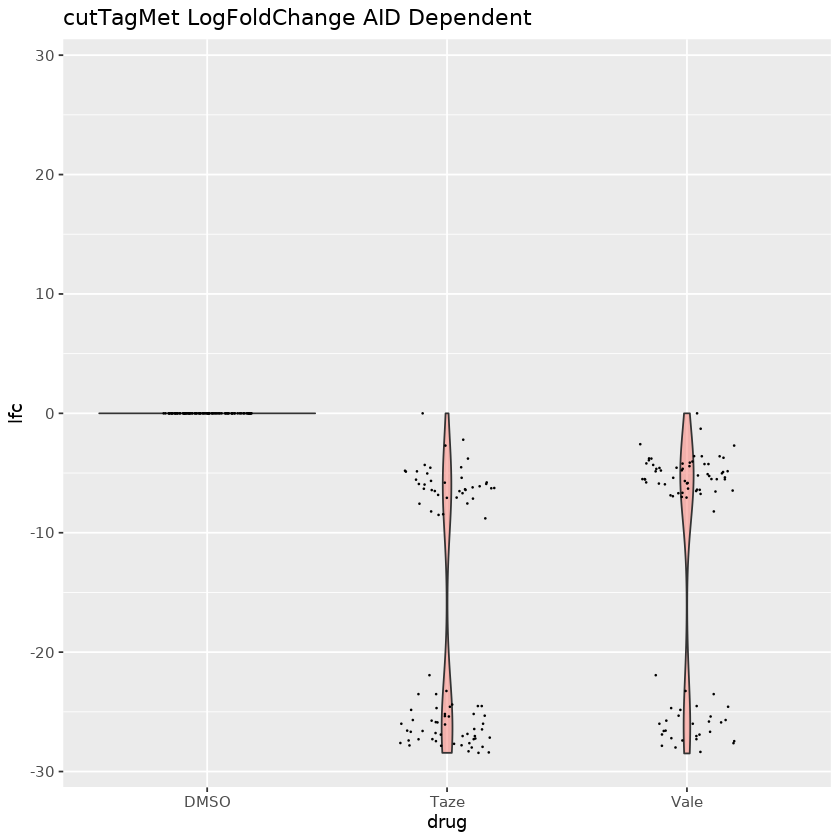

In [9]:
print("pvalue Filtered")
Database=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")
cutTagMet_newrpm=as.matrix(read.table(paste(results,"/cutTagMet_AID_Heatmap_count.csv",sep=""),header=TRUE,row.names=1,sep=","))
filter=unique(union(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/filtered/filtered_Lig_DMSOVale.csv",header=TRUE,row.names=1,sep=",")),rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/filtered/filtered_Lig_DMSOTaze.csv",header=TRUE,row.names=1,sep=","))))
filter=unlist(sapply(filter,FUN=function(x){toString(x)}))
cutTagMet_newrpm=cutTagMet_newrpm[filter,]
write.table(cutTagMet_newrpm,paste(results,"/cutTagMet_AID_Heatmap_RPM_FILTERED.csv",sep=""),col.names=NA,sep=",")
ttmp=cutTagMet_newrpm[which(cutTagMet_newrpm[,1]>=summary(cutTagMet_newrpm[,1])[5]),]
thresholdTheBest=unique(union(names(sort(ttmp[,2]/ttmp[,1],decreasing=TRUE))[seq(1,20)],names(sort(ttmp[,3]/ttmp[,1],decreasing=TRUE))[seq(1,20)]))

foldChange=list()
geneWide=cutTagMet_newrpm+0.000001
filteringTazeBS=names(sort(geneWide[,2],decreasing=TRUE))[seq(1,75)]
filteringValeBS=names(sort(geneWide[,3],decreasing=TRUE))[seq(1,75)]
filteringBS=union(filteringTazeBS,filteringValeBS)


#geneWide=geneWide[filtering,]
foldChange[[1]]=log2(geneWide[,2]/geneWide[,1])
foldChange[[2]]=log2(geneWide[,3]/geneWide[,1])


filteringTazeLFC=names(sort(foldChange[[1]],decreasing=TRUE))[seq(1,75)]
filteringValeLFC=names(sort(foldChange[[2]],decreasing=TRUE))[seq(1,75)]
filteringLFC=union(filteringTazeLFC,filteringValeLFC)

filtering=intersect(filteringBS,filteringLFC)

names(foldChange)=c("Taze","Vale")

foldChangeDF=cbind(foldChange[[1]],rep("Taze",length(foldChange[[1]])))
foldChangeDF=rbind(foldChangeDF,cbind(foldChange[[2]],rep("Vale",length(foldChange[[2]]))))
foldChangeDF=rbind(foldChangeDF,cbind(0,rep("DMSO",length(foldChange[[1]]))))
lim=max(abs(foldChange[[1]]),abs(foldChange[[2]]))

colnames(foldChangeDF)=c("lfc","drug")
foldChangeDF=data.frame(foldChangeDF,check.names=FALSE,fix.empty.names=FALSE)
foldChangeDF$lfc=as.numeric(foldChangeDF$lfc)

pp=ggplot(foldChangeDF,aes(x=drug,y=lfc,fill="red")) +
geom_violin(alpha = 0.5) +
geom_point(position = position_jitter(seed = 1, width = 0.2),size=0.1) +
theme(legend.position = "none") + ylim(-lim,lim) + ggtitle("cutTagMet LogFoldChange AID Dependent")
plot(pp)   
print("Strongest")
tempforever=c()
for(i in filtering){
temp=unique(Database[which(Database[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))
}
write.table(tempforever,(paste(results,"/cutTagMet_filtered_strongest.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)
print("Most DE")
tempforever=c()

for(i in filteringLFC[seq(1,10)]){
temp=unique(Database[which(Database[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))

}
write.table(tempforever,(paste(results,"/cutTagMet_filtered_mostDE.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)
tempforever=c()

print("Most DE with Threshold")
for(i in thresholdTheBest){
temp=unique(Database[which(Database[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))
}
write.table(tempforever,(paste(results,"/cutTagMet_filtered_mostDETreshold.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)

In [10]:
gtf=read.table("/sharedFolder/Data/refGene.gtf",header=TRUE,sep="\t")
a=list.files(pathcutTagMet,pattern=".bed",recursive=TRUE)
uu=grep("sorted",a)
if(length(uu)!=0){
a=a[-uu]
    }
a=mixedsort(a)
a2=sapply(a,FUN=function(x){strsplit(x,".bed")[[1]][1]})
cutTagMet_count=matrix(0,ncol=length(unique(gtf[,4])),nrow=length(a2))
colnames(cutTagMet_count)=sapply(unique(gtf[,4]),FUN=toString)
rownames(cutTagMet_count)=a2
cutTagMet_rpm=cutTagMet_count
for(j in a){
    system(paste("echo",j))
temp=read.table(paste(pathcutTagMet,"/",j,sep=""),sep="\t")
tempGG=GRanges(seqnames=as.matrix(temp[,1]),ranges=IRanges(start = as.numeric(temp[,2]),end=as.numeric(temp[,3])),mcols=abs(as.numeric(temp[,4])))
    for(i in seq(nrow(gtf))){
        system(paste("echo",i/nrow(gtf)))
        gg=GRanges(seqnames=as.matrix(gtf[i,1]),ranges=IRanges(start = as.numeric(gtf[i,2]),end=as.numeric(gtf[i,3])))    
        over=findOverlaps(gg,tempGG)@to    
        name=as.vector(noExt((j)))
        cutTagMet_count[name,toString(gtf[i,4])]= sum(tempGG[over]$mcols)
        cutTagMet_rpm[name,toString(gtf[i,4])]= (sum(tempGG[over]$mcols)/sum(abs(temp[,4])))*1000000

   }

}
conditions=c("DMSO","Taze","Vale")
cutTagMet_newcount=matrix(ncol=ncol(cutTagMet_count))
cutTagMet_newrpm=cutTagMet_newcount
 for(i in conditions){
summa=t(as.matrix(colSums(cutTagMet_count[grep(i,rownames(cutTagMet_count)),])))
cutTagMet_newcount=rbind(cutTagMet_newcount,summa)
summa=t(as.matrix(colSums(cutTagMet_rpm[grep(i,rownames(cutTagMet_rpm)),])))
cutTagMet_newrpm=rbind(cutTagMet_newrpm,summa)

}
cutTagMet_newrpm=cutTagMet_newrpm[-1,]
cutTagMet_newcount=cutTagMet_newcount[-1,]
rownames(cutTagMet_newrpm)=conditions
rownames(cutTagMet_newcount)=conditions

write.table((t(cutTagMet_newcount)),paste(results,"/cutTagMet_geneWide_count.csv",sep=""),col.names=NA,sep=",")
write.table((t(cutTagMet_newrpm)),paste(results,"/cutTagMet_geneWide_RPM.csv",sep=""),col.names=NA,sep=",")


ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 't': error in evaluating the argument 'x' in selecting a method for function 'as.matrix': 'x' must be an array of at least two dimensions


In [ ]:
print("Gene wide ")

write.table((t(cutTagMet_newcount)),paste(results,"/cutTagMet_geneWide_count.csv",sep=""),col.names=NA,sep=",")
ttmp=cutTagMet_newrpm[which(cutTagMet_newrpm[,1]>=summary(cutTagMet_newrpm[,1])[5]),]
thresholdTheBest=unique(union(names(sort(ttmp[,2]/ttmp[,1],decreasing=TRUE))[seq(1,20)],names(sort(ttmp[,3]/ttmp[,1],decreasing=TRUE))[seq(1,20)]))

foldChange=list()
geneWide=cutTagMet_newrpm+0.000001
filteringTazeBS=names(sort(geneWide[,2],decreasing=TRUE))[seq(1,2000)]
filteringValeBS=names(sort(geneWide[,3],decreasing=TRUE))[seq(1,2000)]
filteringBS=union(filteringTazeBS,filteringValeBS)


#geneWide=geneWide[filtering,]
foldChange[[1]]=log2(geneWide[,2]/geneWide[,1])
foldChange[[2]]=log2(geneWide[,3]/geneWide[,1])


filteringTazeLFC=names(sort(foldChange[[1]],decreasing=TRUE))[seq(1,2000)]
filteringValeLFC=names(sort(foldChange[[2]],decreasing=TRUE))[seq(1,2000)]
filteringLFC=union(filteringTazeLFC,filteringValeLFC)

filtering=intersect(filteringBS,filteringLFC)

names(foldChange)=c("Taze","Vale")

foldChangeDF=cbind(foldChange[[1]],rep("Taze",length(foldChange[[1]])))
foldChangeDF=rbind(foldChangeDF,cbind(foldChange[[2]],rep("Vale",length(foldChange[[2]]))))
foldChangeDF=rbind(foldChangeDF,cbind(0,rep("DMSO",length(foldChange[[1]]))))
lim=max(abs(foldChange[[1]]),abs(foldChange[[2]]))

colnames(foldChangeDF)=c("lfc","drug")
foldChangeDF=data.frame(foldChangeDF,check.names=FALSE,fix.empty.names=FALSE)
foldChangeDF$lfc=as.numeric(foldChangeDF$lfc)

pp=ggplot(foldChangeDF,aes(x=drug,y=lfc,fill="red")) +
geom_violin(alpha = 0.5) +
theme(legend.position = "none") + ylim(-lim,lim) + ggtitle("cutTagMet LogFoldChange AID Dependent")
plot(pp)   
print("Strongest")

write.table(filtering,(paste(results,"/cutTagMet_geneWide_Strongest.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)
print("Most DE")
write.table(filteringLFC,(paste(results,"/cutTagMet_geneWide_mostDE.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)


print("Most DE threshold")
write.table(thresholdTheBest,(paste(results,"/cutTagMet_geneWide_mostDETreshold.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)




[1] "RAW"
[1] "Strongest"
[1] "Most DE"
[1] "Most DE with Threshold"


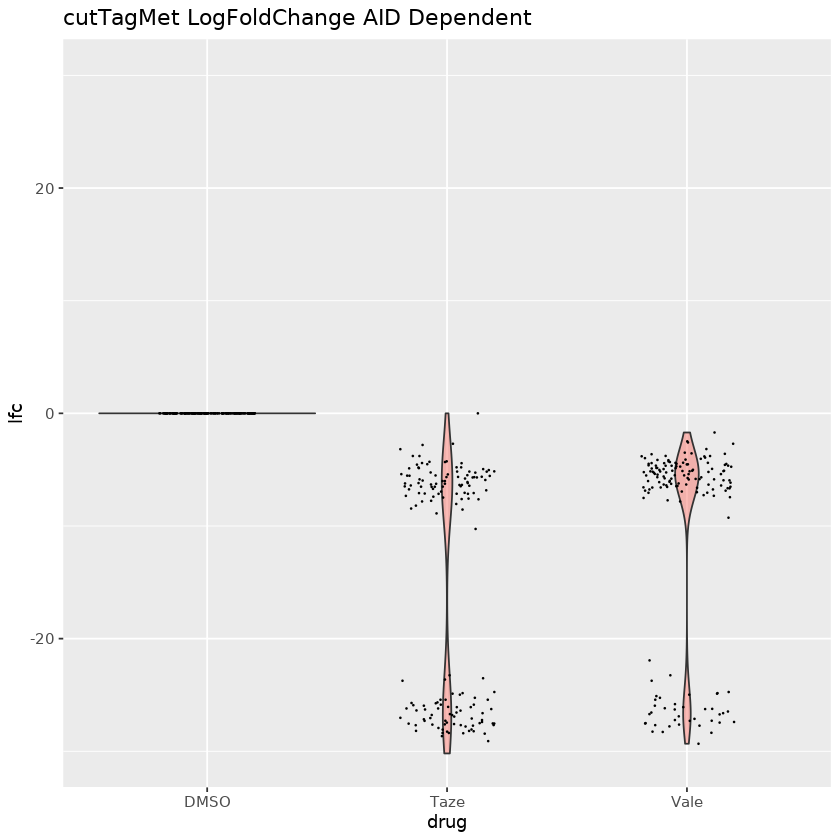

In [3]:
print("RAW")
Database=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")
cutTagMet_newrpm=as.matrix(read.table(paste(results,"/cutTagMet_AID_Heatmap_count.csv",sep=""),header=TRUE,row.names=1,sep=","))
filter=unique(union(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/sortNames/_2_DMSO_TAZE.csv",header=TRUE,row.names=1,sep=",")),rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/sortNames/_5_DMSOVale.csv",header=TRUE,row.names=1,sep=","))))
filter=unlist(sapply(filter,FUN=function(x){toString(x)}))
cutTagMet_newrpm=cutTagMet_newrpm[filter,]


ttmp=cutTagMet_newrpm[which(cutTagMet_newrpm[,1]>=summary(cutTagMet_newrpm[,1])[5]),]
thresholdTheBest=unique(union(names(sort(ttmp[,2]/ttmp[,1],decreasing=TRUE))[seq(1,20)],names(sort(ttmp[,3]/ttmp[,1],decreasing=TRUE))[seq(1,20)]))

foldChange=list()
geneWide=cutTagMet_newrpm+0.000001
filteringTazeBS=names(sort(geneWide[,2],decreasing=TRUE))[seq(1,75)]
filteringValeBS=names(sort(geneWide[,3],decreasing=TRUE))[seq(1,75)]
filteringBS=union(filteringTazeBS,filteringValeBS)


#geneWide=geneWide[filtering,]
foldChange[[1]]=log2(geneWide[,2]/geneWide[,1])
foldChange[[2]]=log2(geneWide[,3]/geneWide[,1])


filteringTazeLFC=names(sort(foldChange[[1]],decreasing=TRUE))[seq(1,75)]
filteringValeLFC=names(sort(foldChange[[2]],decreasing=TRUE))[seq(1,75)]
filteringLFC=union(filteringTazeLFC,filteringValeLFC)

filtering=intersect(filteringBS,filteringLFC)

names(foldChange)=c("Taze","Vale")

foldChangeDF=cbind(foldChange[[1]],rep("Taze",length(foldChange[[1]])))
foldChangeDF=rbind(foldChangeDF,cbind(foldChange[[2]],rep("Vale",length(foldChange[[2]]))))
foldChangeDF=rbind(foldChangeDF,cbind(0,rep("DMSO",length(foldChange[[1]]))))
lim=max(abs(foldChange[[1]]),abs(foldChange[[2]]))

colnames(foldChangeDF)=c("lfc","drug")
foldChangeDF=data.frame(foldChangeDF,check.names=FALSE,fix.empty.names=FALSE)
foldChangeDF$lfc=as.numeric(foldChangeDF$lfc)

pp=ggplot(foldChangeDF,aes(x=drug,y=lfc,fill="red")) +
geom_violin(alpha = 0.5) +
geom_point(position = position_jitter(seed = 1, width = 0.2),size=0.1) +
theme(legend.position = "none") + ylim(-lim,lim) + ggtitle("cutTagMet LogFoldChange AID Dependent")
plot(pp)   
print("Strongest")
tempforever=c()
for(i in filtering){
temp=unique(Database[which(Database[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))
}
write.table(tempforever,(paste(results,"/cutTagMet_raw_strongest.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)
print("Most DE")
tempforever=c()

for(i in filteringLFC[seq(1,10)]){
temp=unique(Database[which(Database[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))

}
write.table(tempforever,(paste(results,"/cutTagMet_raw_mostDE.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)
tempforever=c()

print("Most DE with Threshold")
for(i in thresholdTheBest){
temp=unique(Database[which(Database[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))
}
write.table(tempforever,(paste(results,"/cutTagMet_raw_mostDETreshold.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)

[1] "RAW"
[1] "Strongest"
[1] "Most DE"
[1] "Most DE with Threshold"


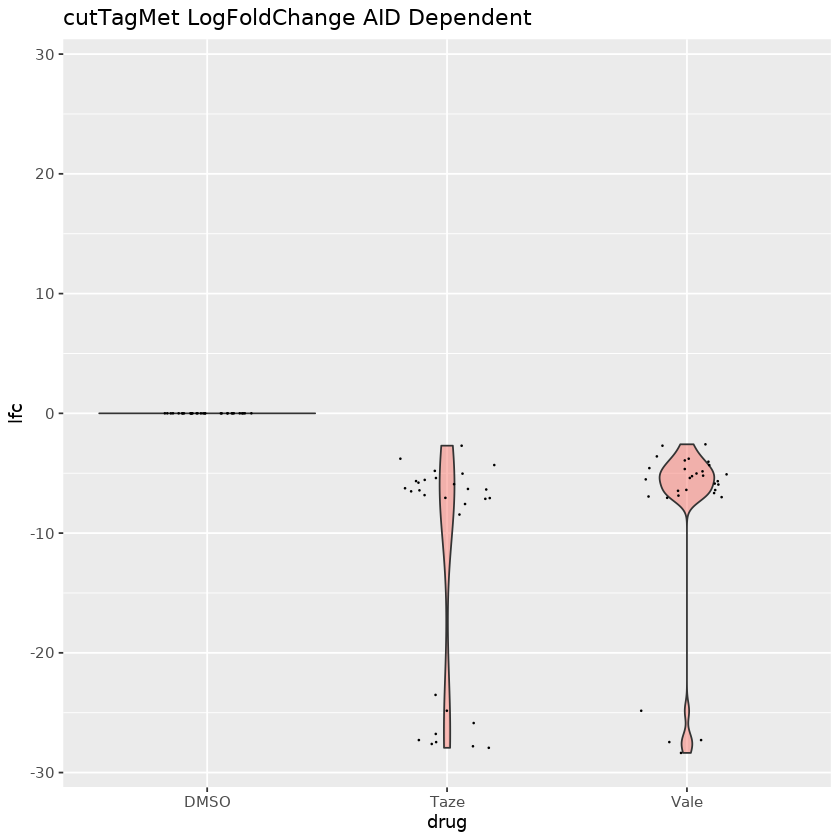

In [4]:
print("RAW")
Database=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")
cutTagMet_newrpm=as.matrix(read.table(paste(results,"/cutTagMet_AID_Heatmap_count.csv",sep=""),header=TRUE,row.names=1,sep=","))
filter=unique(union(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/filtered/sortNames/_2_DMSO_TAZE.csv",header=TRUE,row.names=1,sep=",")),rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/filtered/sortNames/_5_DMSOVale.csv",header=TRUE,row.names=1,sep=","))))
filter=unlist(sapply(filter,FUN=function(x){toString(x)}))
cutTagMet_newrpm=cutTagMet_newrpm[filter,]


ttmp=cutTagMet_newrpm[which(cutTagMet_newrpm[,1]>=summary(cutTagMet_newrpm[,1])[5]),]
thresholdTheBest=unique(union(names(sort(ttmp[,2]/ttmp[,1],decreasing=TRUE))[seq(1,20)],names(sort(ttmp[,3]/ttmp[,1],decreasing=TRUE))[seq(1,20)]))

foldChange=list()
geneWide=cutTagMet_newrpm+0.000001
filteringTazeBS=names(sort(geneWide[,2],decreasing=TRUE))[seq(1,75)]
filteringValeBS=names(sort(geneWide[,3],decreasing=TRUE))[seq(1,75)]
filteringBS=union(filteringTazeBS,filteringValeBS)


#geneWide=geneWide[filtering,]
foldChange[[1]]=log2(geneWide[,2]/geneWide[,1])
foldChange[[2]]=log2(geneWide[,3]/geneWide[,1])


filteringTazeLFC=names(sort(foldChange[[1]],decreasing=TRUE))[seq(1,75)]
filteringValeLFC=names(sort(foldChange[[2]],decreasing=TRUE))[seq(1,75)]
filteringLFC=union(filteringTazeLFC,filteringValeLFC)

filtering=intersect(filteringBS,filteringLFC)

names(foldChange)=c("Taze","Vale")

foldChangeDF=cbind(foldChange[[1]],rep("Taze",length(foldChange[[1]])))
foldChangeDF=rbind(foldChangeDF,cbind(foldChange[[2]],rep("Vale",length(foldChange[[2]]))))
foldChangeDF=rbind(foldChangeDF,cbind(0,rep("DMSO",length(foldChange[[1]]))))
lim=max(abs(foldChange[[1]]),abs(foldChange[[2]]))

colnames(foldChangeDF)=c("lfc","drug")
foldChangeDF=data.frame(foldChangeDF,check.names=FALSE,fix.empty.names=FALSE)
foldChangeDF$lfc=as.numeric(foldChangeDF$lfc)

pp=ggplot(foldChangeDF,aes(x=drug,y=lfc,fill="red")) +
geom_violin(alpha = 0.5) +
geom_point(position = position_jitter(seed = 1, width = 0.2),size=0.1) +
theme(legend.position = "none") + ylim(-lim,lim) + ggtitle("cutTagMet LogFoldChange AID Dependent")
plot(pp)   
print("Strongest")
tempforever=c()
for(i in filtering){
temp=unique(Database[which(Database[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))
}
write.table(tempforever,(paste(results,"/cutTagMet_raw_strongest.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)
print("Most DE")
tempforever=c()

for(i in filteringLFC[seq(1,10)]){
temp=unique(Database[which(Database[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))

}
write.table(tempforever,(paste(results,"/cutTagMet_raw_mostDE.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)
tempforever=c()

print("Most DE with Threshold")
for(i in thresholdTheBest){
temp=unique(Database[which(Database[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))
}
write.table(tempforever,(paste(results,"/cutTagMet_raw_mostDETreshold.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)